# Experimenting with least squares and its variants

In [1]:
%matplotlib inline

from sklearn import datasets
from scipy.optimize import fmin_bfgs
import numpy as np
from numpy.linalg import norm
from numpy.linalg import inv

## Data preparation

First step to apply the formulae we learnt during the lectures is to rewrite the dataset in homogeneous coordinates (i.e., we append a column of 1 to the matrix containing the examples):

In [2]:
boston = datasets.load_boston()
data = np.array(boston.data)
data.shape

t = np.ones(len(data)).reshape(len(data),1)
data = np.append(data, t, 1)
target = np.array(boston.target)
data.shape

(506, 14)

We now divide the data into a training set $X$ and a test set $X_\textrm{test}$.

In [3]:
X,y = data[0:400,:], target[0:400]
X_test, y_test = data[400:,:], target[400:]

# Exercise

1. Calculate the least square solution (to the regression problem outlined above) and evaluate its performances on the training set and on the test set.
1. Calculate the ridge regression solution (set lambda to 0.01) and evaluate its performances on the training set and on test set.
1. Calculate the lasso regression solution and evaluate its performances on the training set and on the test set.

## Notes

- Here it follows a list of functions you may want to use (the required packages are already imported at the beginning of this notebook) along with a very brief explanation of their purpose (`help(nomefun)` will provide you more information about function `nomefun`):
    - `transpose`: matrix transposition (e.g., `transpose(X)`)
    - `dot`: matrix multiplication (e.g., `X.dot(X2)`) 
    - `inv`: matrix inversion (e.g., `inv(X)`)
- to solve the lasso problem you will need to perform a numerical minimization of the associated loss function (as you know, a closed form solution does not exist). There are many numerical optimization algorithms available in the scipy package. My suggestion is to use `fmin_bfgs`. Here it follows an example of how to use it:
    ```python
        def f(w):
            return w[0]**2 + w[1]**2 + w[0] + w[1]
        
        w = fmin_bfgs(f, [0,0])
    ```
    note that the function may (and should) reference your data variables (i.e., $X$ and $y$).
- to evaluate the performances of your solutions use the $S$ statistic:
    $$
        S =  \sqrt{ \frac{1}{n} \sum_{i=1}^n (y_i' - y_i)^2 }
    $$
    where $y'_i$ is your model prediction for the i-th example, and $n$ is the number of examples.

# Exercise \#1: Least squares for Linear Regression

From the theory, we know that the optimal solution $w^*$ to the least squares that minimize the residuals sum have a closed form:
$$ w^* = X^+y =(X^TX)^{-1}X^Ty$$

In [4]:
w = np.linalg.pinv(X).dot(y)
w

array([-1.91246374e-01,  4.42289967e-02,  5.52207977e-02,  1.71631351e+00,
       -1.49957220e+01,  4.88773025e+00,  2.60921031e-03, -1.29480799e+00,
        4.84787214e-01, -1.54006673e-02, -8.08795026e-01, -1.29230427e-03,
       -5.17953791e-01,  2.86725996e+01])

To check if our results are consistent with more robust implementation, we compare our "custom" implementation with the one provided by sci-kit learn package

In [5]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(X,y) # fit sklearn model to data

custom_predictions = X_test.dot(w)
sklearn_predictions = reg.predict(X_test)

msg = "Custom and sklearn weight vector are {}!"
print(msg.format("equal")) if np.allclose(w, reg.coef_) else print(msg.format("different"))

Custom and sklearn weight vector are equal!


### Evaluate model performance
To evaluate the model performance, we compute the error on the *test set* using the RMSE metric.
Since RMSE is expressed in the same unit scale of the target variable, to asses qualitatively the goodness of RMSE we check the regression variable range ($y_{max}-y_{min}$)

In [6]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y,X.dot(w),squared=False)
rmse_test = mean_squared_error(y_test,custom_predictions,squared=False)
print("Model's RMSE on train: {:.3f}\nModel's RMSE on test: {:.3f}\nTarget variable scale: {}".format(rmse_train,rmse_test, np.ptp(target)))



Model's RMSE on train: 4.723
Model's RMSE on test: 6.156
Target variable scale: 45.0


## Exercise \#2: Use Ridge Regularization
To make our model more robust to noise error into the data, we can apply the most basic regularization's technique: the *ridge regularization* method (aka *Tikhonov* regularization). In layman's terms this method apply a simple **constraint** on the model' weights vector constraining it's squared norm $||\cdot||_2$. The regularization contribution can be tweaked by the *shrinkage parameter* $\lambda$. The solution $w^*$ to the optimization problem could be rewrited as:

$$ w^* = \operatorname*{argmin}_w || y-Xw||^2_2 + \lambda ||w||_2^2 $$

Also in this case we have a closed form solution:
$$ w^* =(X^TX + \lambda I)^{-1}X^Ty$$


In [7]:
shrinkage =0.01 # tweak shrinkage parameter

def custom_ridge(X,y,shrinkage):
    square_matrix = np.matmul(X.T,X)
    I = np.identity(square_matrix.shape[0]) * shrinkage
    inverse = np.linalg.inv(square_matrix + I)

    w_ridge = np.matmul(inverse,X.T).dot(y)
    
    return w_ridge
w_ridge = custom_ridge(X,y,shrinkage)
w_ridge

array([-1.91440894e-01,  4.42725237e-02,  5.43610777e-02,  1.71562849e+00,
       -1.46631854e+01,  4.91104161e+00,  2.40041390e-03, -1.28746240e+00,
        4.82736224e-01, -1.53750112e-02, -8.01618031e-01, -1.05056023e-03,
       -5.16996650e-01,  2.81110919e+01])

### Compare with sci-kit learn implementation

In [8]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=shrinkage,fit_intercept=False)
ridge_reg.fit(X,y) # fit sklearn model to data

msg = "Custom  and sklearn regression coefficients are {}!"
print(msg.format("equal")) if np.allclose(w_ridge, ridge_reg.coef_) else print(msg.format("different"))

Custom  and sklearn regression coefficients are equal!


### Evaluate model performance

In [9]:
predictions = X_test.dot(w_ridge)

rmse_train = mean_squared_error(y,X.dot(w_ridge),squared=False)
rmse_test = mean_squared_error(y_test,predictions,squared=False)
print("Model's RMSE on train: {:.3f}\nModel's RMSE on test: {:.3f}\nTarget variable scale: {}".format(rmse_train,rmse_test, np.ptp(target)))

Model's RMSE on train: 4.723
Model's RMSE on test: 6.142
Target variable scale: 45.0


### Shrinkage effect visualization
To asses how weights changed when $\lambda$ gets higher value, we train a different model with increasing shrinkage coefficient and than plot a line for each weight

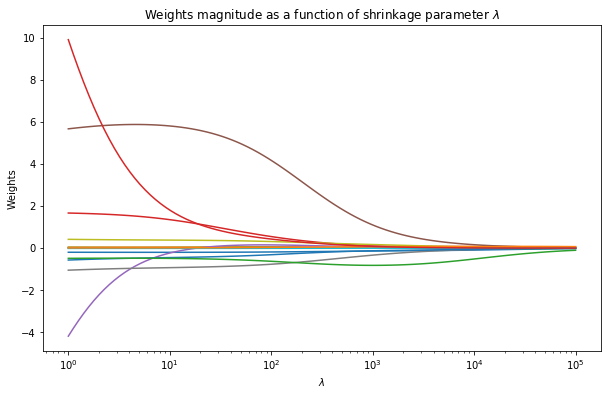

In [10]:
import matplotlib.pyplot as plt

shrinkages = np.logspace(0,5,100)

coeffs=[]
for s in shrinkages:
    w = custom_ridge(X,y,s)
    coeffs.append(w)
    
    
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(shrinkages,coeffs)

ax.set_xscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Weights")
ax.set_title("Weights magnitude as a function of shrinkage parameter $\lambda$");

## Exercise \#3: Use LASSO Regularization
Lasso regualarization methods is similar to the previus one, the main difference is that the constraint is expressed in $||\cdot||_1$ norm. The solution $w^*$ to the optimization problem could be rewritten as:
$$
w^* = \operatorname*{minimize}_w ||y-Xw||^2_2 + \lambda||w||_1
$$



Unfortunately there's **no closed form solution**, so we must use an iterative optimization method to minimize the loss function

In [11]:
import scipy.optimize as opt

In [12]:
t = np.ones(len(data)).reshape(len(data),1)
data = np.append(data, t, 1)
target = np.array(boston.target)
data.shape

X,y = data[0:400,:], target[0:400]
X_test, y_test = data[400:,:], target[400:]

In [13]:
def lasso_loss(w,X,y,shrinkage):
    pred = X.dot(w) # get prediction (y'=X*w)
    ssd = np.sum((y-pred)**2) # sum of squared differences
    
    return  (1/(2*X.shape[0])) * ssd + shrinkage * np.linalg.norm(w,ord=1) #same formula used by sklearn Lasso implementation """"""

def lasso_fit(X,y,shrinkage):
    
    w_init = np.zeros(X.shape[1]) # null weights initilization scheme
    res = opt.minimize(lasso_loss, x0=w_init, args=(X,y,shrinkage),
                       method='Powell',options={'maxiter':100000,'disp':True})
    return res['x']

In [14]:
w_lasso = lasso_fit(X,y,shrinkage=2.5)
w_lasso

Optimization terminated successfully.
         Current function value: 25.382821
         Iterations: 22
         Function evaluations: 6790


array([-5.09436417e-02,  5.86596856e-02,  3.83946424e-06,  0.00000000e+00,
        0.00000000e+00,  1.48595994e+00,  8.20648121e-02,  0.00000000e+00,
       -7.03917622e-09,  3.54489988e-03,  2.07905586e-08,  4.39891851e-02,
       -8.23802443e-01,  5.57174199e-12, -1.77273966e-12])

### Evaluate Model Performance

In [15]:
predictions = X_test.dot(w_lasso)

rmse_train = mean_squared_error(y,X.dot(w_lasso),squared=False)
rmse_test = mean_squared_error(y_test,predictions,squared=False)
print("Model's RMSE on train: {:.3f}\nModel's RMSE on test: {:.3f}\nTarget variable scale: {}".format(rmse_train,rmse_test, np.ptp(target)))

Model's RMSE on train: 6.166
Model's RMSE on test: 7.631
Target variable scale: 45.0


#### Sklearn Lasso Implementation Comparison

In [16]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=2.5)
lasso.fit(X,y)
rmse_train = mean_squared_error(y,lasso.predict(X),squared=False)
rmse_test = mean_squared_error(y_test,lasso.predict(X_test),squared=False)
print("Model's RMSE on train: {:.3f}\nModel's RMSE on test: {:.3f}\nTarget variable scale: {}".format(rmse_train,rmse_test, np.ptp(target)))

Model's RMSE on train: 5.907
Model's RMSE on test: 4.534
Target variable scale: 45.0


We can see that sklearn lasso implemention have a sparse weight vector:

In [17]:
lasso.coef_

array([-0.        ,  0.03686395, -0.        ,  0.        ,  0.        ,
        0.        ,  0.059244  , -0.06243391,  0.20312011, -0.01205994,
       -0.47308683,  0.01031908, -0.90971843,  0.        ,  0.        ])